Training Analysis PCA

In [ ]:
import pandas as pd

df = pd.read_pickle("test/test_llm_generations.pkl")

labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df['popularity_bin'] = pd.qcut(df['popularity'], q=5, labels=labels)


#labels = ['Low', 'Medium', 'High']
#df['popularity_bin'] = pd.qcut(df['popularity'], q=3, labels=labels)

In [ ]:
from sklearn.utils import resample
import pandas as pd

# Step 1: Determine the common sample size for each bin after class balancing
min_bin_size = min(
    min(len(group[group['label_mini_fact'] == 1]), len(group[group['label_mini_fact'] == 0]))
    for _, group in df.groupby('popularity_bin')
)

# Step 2: Balance classes within each bin and resample to the common sample size
balanced_dfs = []
for bin_label, group in df.groupby('popularity_bin'):
    # Separate the classes within the bin
    positive_class = group[group['label_mini_fact'] == 1]
    negative_class = group[group['label_mini_fact'] == 0]
    
    # Balance the classes by undersampling
    positive_class_balanced = resample(positive_class, replace=False, n_samples=min_bin_size, random_state=42)
    negative_class_balanced = resample(negative_class, replace=False, n_samples=min_bin_size, random_state=42)
    print(f"Balancing bin '{bin_label}' with {min_bin_size} samples in each class")
    
    # Combine the balanced classes within the bin
    balanced_group = pd.concat([positive_class_balanced, negative_class_balanced])
    
    # Resample the bin to the common bin size (2 * min_bin_size)
    balanced_group = resample(balanced_group, replace=False, n_samples=2 * min_bin_size, random_state=42)
    balanced_dfs.append(balanced_group)

# Combine all balanced bins into a single DataFrame
balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Step 3: Perform PCA and plot each popularity bin
fig, axes = plt.subplots(1, 5, figsize=(16, 5))  # Set square figsize
popularity_bins = labels

for i, bin_label in enumerate(popularity_bins):
    # Filter the data for the current popularity bin
    filtered_df = balanced_df[balanced_df['popularity_bin'] == bin_label].copy()
    
    # Extract features and labels
    X = list(filtered_df['embeddings-16_mini_fact'])
    y = filtered_df['label_mini_fact'].values

    # Perform PCA to reduce dimensionality to 2 components
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Separate positive and negative samples for custom transparency
    X_pca_positive = X_pca[y == 1]
    X_pca_negative = X_pca[y == 0]

    # Plotting PCA results for the current bin
    axes[i].scatter(X_pca_positive[:, 0], X_pca_positive[:, 1], c='yellow', alpha=0.7, label='Positive (Label 1)')
    axes[i].scatter(X_pca_negative[:, 0], X_pca_negative[:, 1], c='purple', alpha=0.7, label='Negative (Label 0)')
    
    # Set title and labels
    axes[i].set_title(f"{bin_label} Popularity")
    axes[i].set_xlabel("PCA Component 1")
    axes[i].set_ylabel("PCA Component 2")
    axes[i].set_aspect('equal')  # Set equal aspect ratio
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()



Tests

In [ ]:
import pandas as pd

df_train = pd.read_pickle("train/train_injection_low_popularity_with_embeddings.pkl")
print(len(df_train))

5282


: 

In [ ]:
18548

In [ ]:
df_train.loc[df_train['label_mini_fact'] == 1]

In [ ]:
import pandas as pd

df_train = pd.read_pickle("train/train_with_popularity_unbalanced.pkl")
print(len(df_train))

df_train["closest_article"] = df_train["closest_article"].apply(lambda x: x[0] if isinstance(x, list) else x)

df_test1 = pd.read_pickle("test/test_llm_generations.pkl")
df_test2 = pd.read_pickle("test/test_all_popularity_real_samples.pkl")
df_test = pd.concat([df_test1, df_test2], ignore_index=True)
df_test["closest_article"] = df_test["closest_article"].apply(lambda x: x[0] if isinstance(x, list) else x)

In [ ]:
from itertools import chain

#train_mini_facts_docs = list(set(chain.from_iterable(df_train['closest_article'])))
train_mini_facts_docs = df_train['closest_article'].tolist()

#test_mini_facts_docs = list(set(chain.from_iterable(df_test['docs'])))
test_mini_facts_docs = df_test['closest_article'].tolist()

for train_mini_facts_doc_t in train_mini_facts_docs:
    if train_mini_facts_doc_t in test_mini_facts_docs:
        print(train_mini_facts_doc_t)


for test_mini_facts_doc_t in test_mini_facts_docs:
    if test_mini_facts_doc_t in train_mini_facts_docs:
        print(test_mini_facts_doc_t)

Results

In [44]:
import pandas as pd

df_predictions1 = pd.read_pickle("predictions/prediction_with_train_popularity_unbalanced.pkl")
save_path1 = "with_train_popularity_unbalanced"
df_predictions2 = pd.read_pickle("predictions/prediction_with_train_popularity_balanced.pkl")
save_path2 = "with_train_popularity_balanced"
df_predictions3 = pd.read_pickle("predictions/prediction_with_real_samples_with_train_popularity_balanced.pkl")
save_path3 = "with_real_samples_with_train_popularity_balanced"
df_predictions4 = pd.read_pickle("predictions/prediction_with_real_samples_with_train_popularity_balanced_train_injections.pkl")
save_path4 = "with_real_samples_with_train_popularity_balanced_train_injections"

df = df_predictions4.copy()
save_path = save_path4

In [ ]:
print(len(df))

In [45]:
import pandas as pd

# Assuming your DataFrame is already loaded
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df['popularity_bin'] = pd.qcut(df['popularity'], q=5, labels=labels)

# Get bin ranges
bin_ranges = pd.qcut(df['popularity'], q=5).cat.categories

# Map labels to bin ranges
bin_label_mapping = {label: bin_range for label, bin_range in zip(labels, bin_ranges)}

# Display the mapping of labels to ranges
print("Bin Ranges and Labels:")
for label, bin_range in bin_label_mapping.items():
    print(f"{label}: {bin_range}")

# Get the number of samples in each bin
print("\nNumber of Samples in Each Bin:")
sample_counts = df['popularity_bin'].value_counts(sort=False)  # Keep original bin order
for label, count in sample_counts.items():
    print(f"{label}: {count}")


Bin Ranges and Labels:
Very Low: (-0.001, 2063.8]
Low: (2063.8, 12470.0]
Medium: (12470.0, 53421.0]
High: (53421.0, 303828.2]
Very High: (303828.2, 3801993.0]

Number of Samples in Each Bin:
Very Low: 679
Low: 679
Medium: 680
High: 675
Very High: 679


In [46]:
from sklearn.utils import resample
import pandas as pd

# Step 1: Determine the common sample size for each bin after class balancing
min_bin_size = min(
    min(len(group[group['label_mini_fact'] == 1]), len(group[group['label_mini_fact'] == 0]))
    for _, group in df.groupby('popularity_bin')
)

# Step 2: Balance classes within each bin and resample to the common sample size
balanced_dfs = []
for bin_label, group in df.groupby('popularity_bin'):
    # Separate the classes within the bin
    positive_class = group[group['label_mini_fact'] == 1]
    negative_class = group[group['label_mini_fact'] == 0]
    
    # Balance the classes by undersampling
    positive_class_balanced = resample(positive_class, replace=False, n_samples=min_bin_size, random_state=42)
    negative_class_balanced = resample(negative_class, replace=False, n_samples=min_bin_size, random_state=42)
    print(f"Balancing bin '{bin_label}' with {min_bin_size} samples in each class")
    
    # Combine the balanced classes within the bin
    balanced_group = pd.concat([positive_class_balanced, negative_class_balanced])
    
    # Resample the bin to the common bin size (2 * min_bin_size)
    balanced_group = resample(balanced_group, replace=False, n_samples=2 * min_bin_size, random_state=42)
    balanced_dfs.append(balanced_group)

# Combine all balanced bins into a single DataFrame
balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)


Balancing bin 'Very Low' with 175 samples in each class
Balancing bin 'Low' with 175 samples in each class
Balancing bin 'Medium' with 175 samples in each class
Balancing bin 'High' with 175 samples in each class
Balancing bin 'Very High' with 175 samples in each class


C:\Users\droeh\AppData\Local\Temp\ipykernel_25640\1640967162.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, group in df.groupby('popularity_bin')
C:\Users\droeh\AppData\Local\Temp\ipykernel_25640\1640967162.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_label, group in df.groupby('popularity_bin'):


F1 

Size of each bin:
popularity_bin
Very Low     350
Low          350
Medium       350
High         350
Very High    350
Name: count, dtype: int64


C:\Users\droeh\AppData\Local\Temp\ipykernel_25640\2746395465.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_label, group in balanced_df.groupby('popularity_bin'):


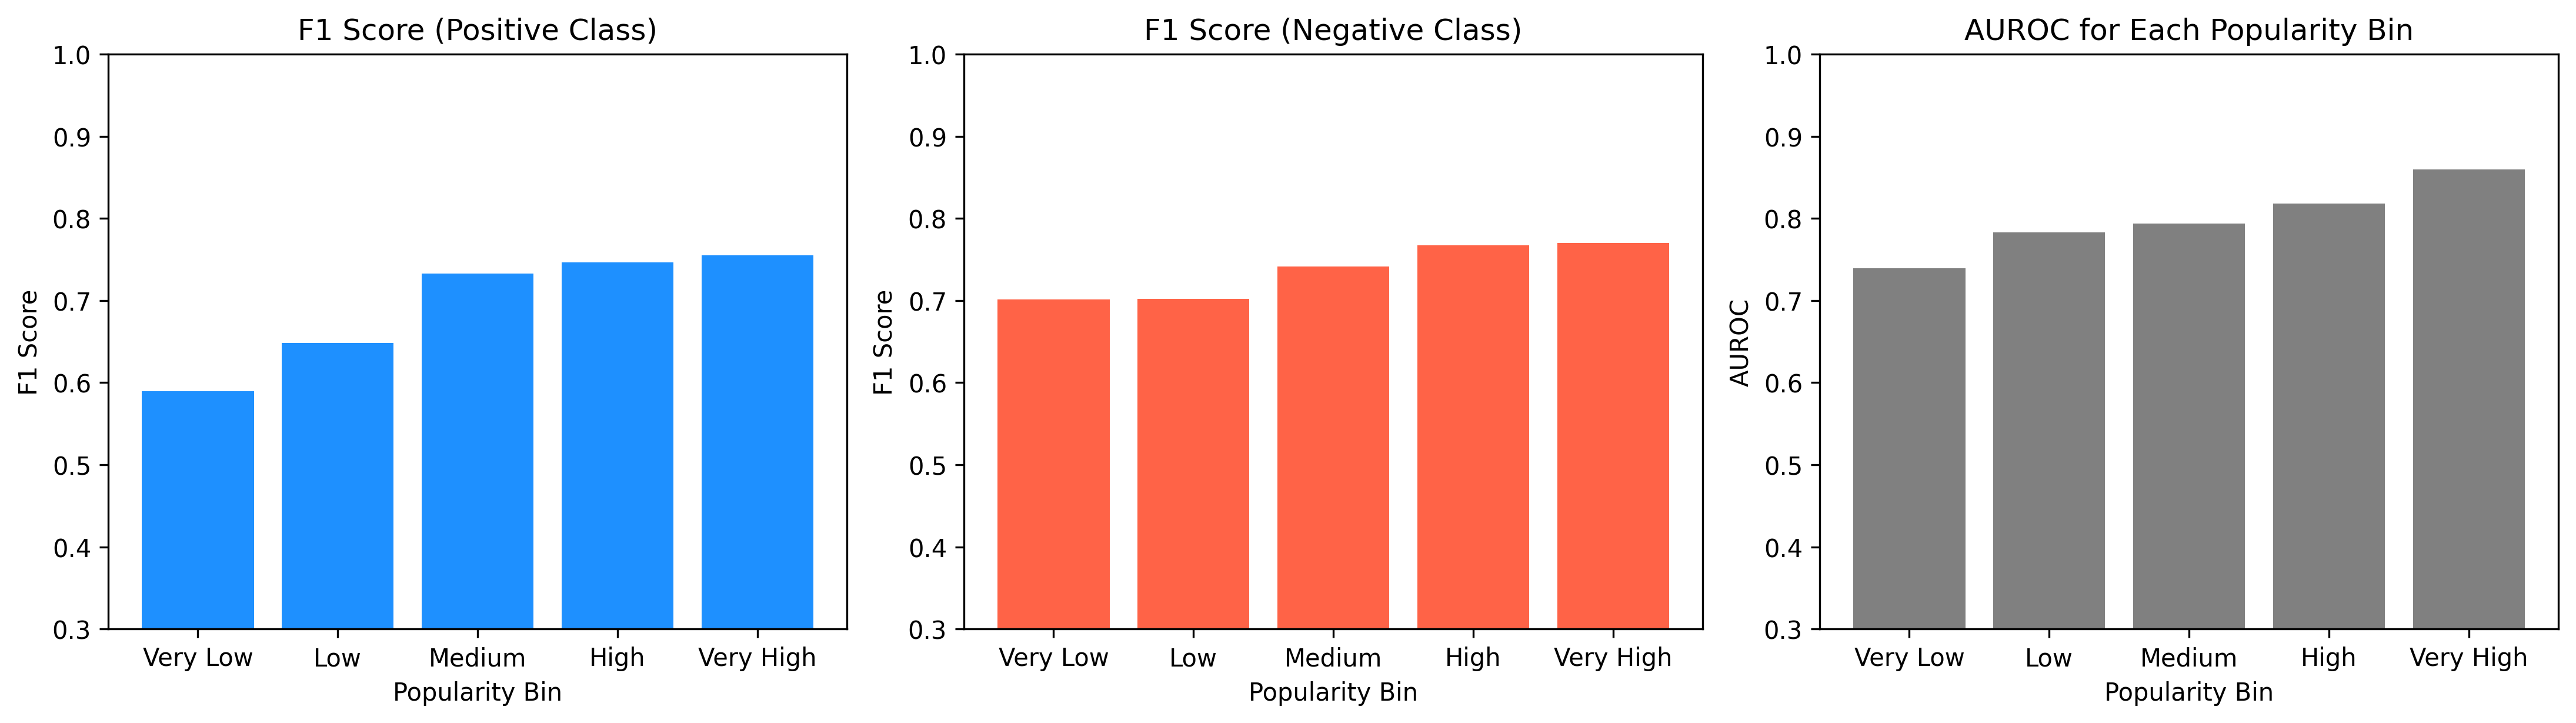

Overall AUROC: 0.8006


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score

# Assuming 'balanced_df' is already loaded with columns 'popularity_bin', 'label_mini_fact', 'pred_prob'

# Step 1: Print the size of each bin
print("Size of each bin:")
bin_sizes = balanced_df['popularity_bin'].value_counts().sort_index()
print(bin_sizes)

# Step 2: Calculate F1 Scores for positive and negative classes for each bin
f1_scores_positive = {}
f1_scores_negative = {}
auroc_scores = {}

for bin_label, group in balanced_df.groupby('popularity_bin'):
    predictions = (group['pred_prob'] >= 0.5).astype(int)
    if group['label_mini_fact'].nunique() > 1:
        f1_scores_positive[bin_label] = f1_score(group['label_mini_fact'], predictions)
        f1_scores_negative[bin_label] = f1_score(1 - group['label_mini_fact'], 1 - predictions)
        auroc_scores[bin_label] = roc_auc_score(group['label_mini_fact'], group['pred_prob'])
    else:
        f1_scores_positive[bin_label] = np.nan
        f1_scores_negative[bin_label] = np.nan
        auroc_scores[bin_label] = np.nan

# Convert F1 and AUROC scores to DataFrames
f1_df_positive = pd.DataFrame(list(f1_scores_positive.items()), columns=['popularity_bin', 'f1_score_positive'])
f1_df_negative = pd.DataFrame(list(f1_scores_negative.items()), columns=['popularity_bin', 'f1_score_negative'])
auroc_df = pd.DataFrame(list(auroc_scores.items()), columns=['popularity_bin', 'auroc'])

# Plotting F1 Scores and AUROC in one row with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(21*0.7, 6*0.7))

# Plot F1 Score for Positive Class
axes[0].bar(f1_df_positive['popularity_bin'], f1_df_positive['f1_score_positive'], color='dodgerblue')
axes[0].set_title('F1 Score (Positive Class)')
axes[0].set_xlabel('Popularity Bin')
axes[0].set_ylim(0.3, 1)  # Set y-axis range
axes[0].set_ylabel('F1 Score')

# Plot F1 Score for Negative Class
axes[1].bar(f1_df_negative['popularity_bin'], f1_df_negative['f1_score_negative'], color='tomato')
axes[1].set_title('F1 Score (Negative Class)')
axes[1].set_xlabel('Popularity Bin')
axes[1].set_ylim(0.3, 1)  # Set y-axis range
axes[1].set_ylabel('F1 Score')

# Plot AUROC for each bin
axes[2].bar(auroc_df['popularity_bin'], auroc_df['auroc'], color='grey')
axes[2].set_title('AUROC for Each Popularity Bin')
axes[2].set_xlabel('Popularity Bin')
axes[2].set_ylim(0.3, 1)  # Set y-axis range
axes[2].set_ylabel('AUROC')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Calculate and print overall AUROC
overall_auroc = roc_auc_score(balanced_df['label_mini_fact'], balanced_df['pred_prob'])
print(f"Overall AUROC: {overall_auroc:.4f}")

fig.savefig(f"f1_{save_path}.png", dpi=300, bbox_inches='tight')



Prob Distribution

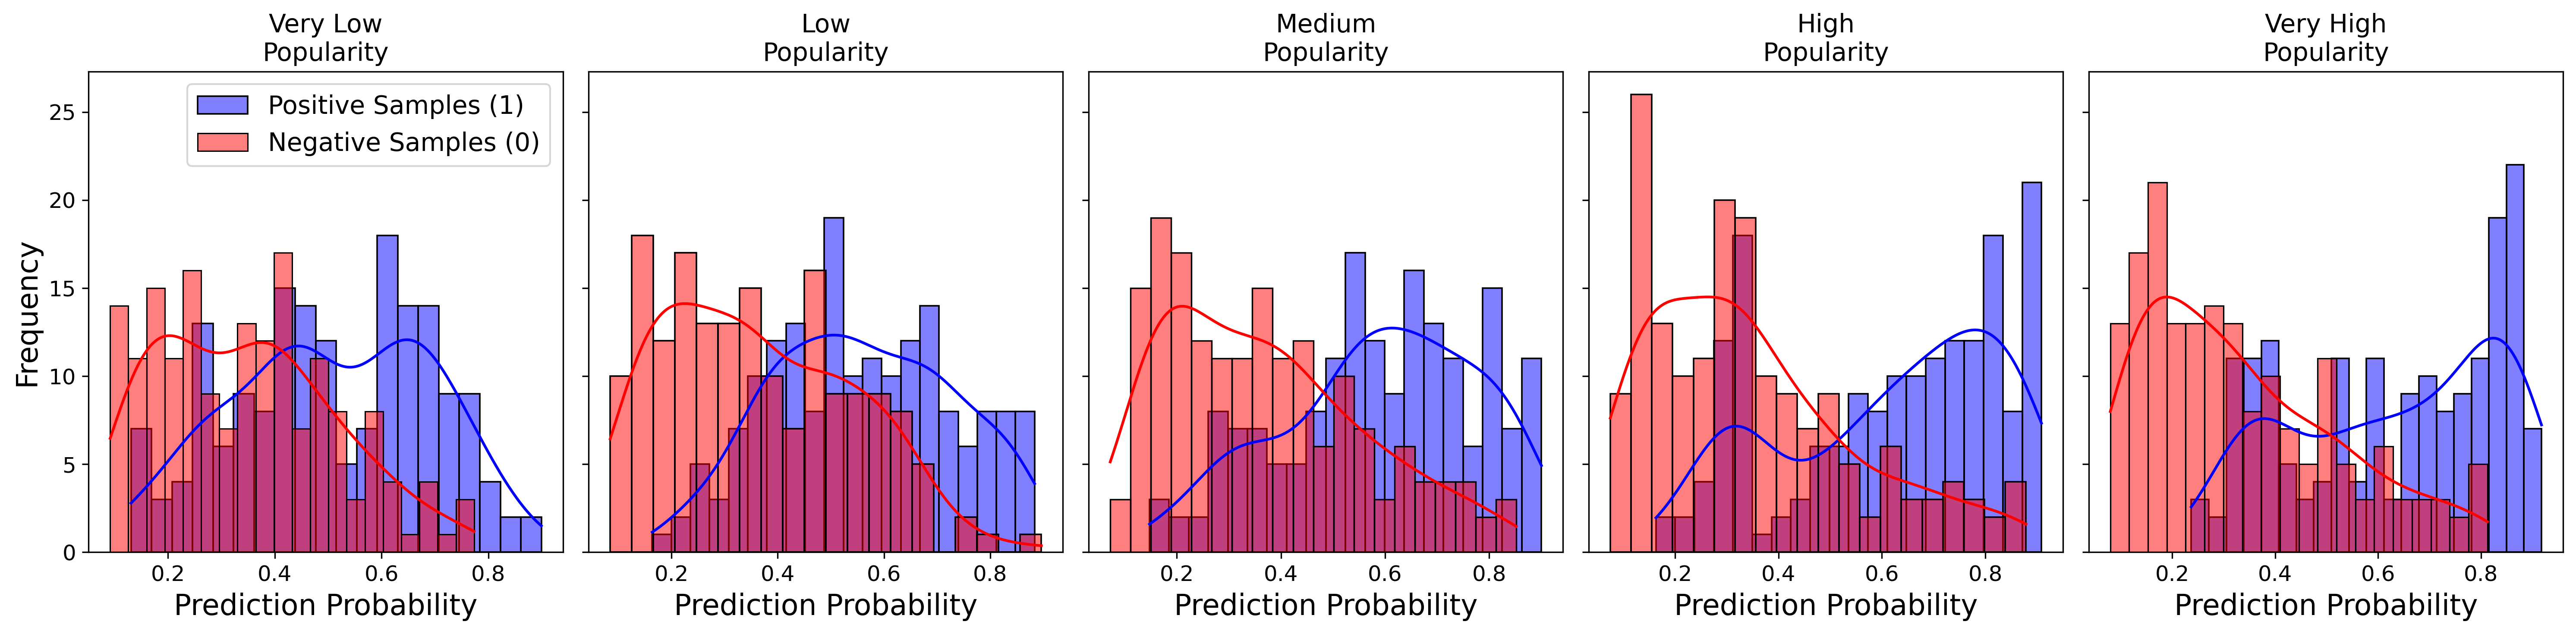

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure DPI for better quality
plt.rcParams['figure.dpi'] = 300

# Increase height by changing figsize
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)  # Adjust height here

# Plot probability distribution for each popularity bin
for i, bin_label in enumerate(labels):
    # Filter samples for the current bin
    bin_samples = balanced_df[balanced_df['popularity_bin'] == bin_label]
    
    # Separate positive and negative samples
    positive_samples = bin_samples[bin_samples['label_mini_fact'] == 1]
    negative_samples = bin_samples[bin_samples['label_mini_fact'] == 0]
    
    # Plot distribution of prediction probabilities for positive and negative samples
    sns.histplot(positive_samples['pred_prob'], bins=20, kde=True, color='blue', label='Positive Samples (1)', ax=axes[i])
    sns.histplot(negative_samples['pred_prob'], bins=20, kde=True, color='red', label='Negative Samples (0)', ax=axes[i])
    
    # Set plot titles and labels with increased font size
    title_text = f"{bin_label}\nPopularity" #f"Pred Prob Distribution\n- {bin_label} Popularity" if i == 0 else f"{bin_label}\nPopularity"
    axes[i].set_title(title_text, fontsize=14)  # Increase title font size
    axes[i].set_xlabel('Prediction Probability', fontsize=16)  # Increase x-axis label font size
    
    # Set y-axis label on the first plot with the label "Frequency"
    if i == 0:
        axes[i].set_ylabel('Frequency', fontsize=16)  # Increase y-axis label font size
    
    # Set tick label font size for x and y axis
    axes[i].tick_params(axis='x', labelsize=12)  # Increase x-axis tick font size
    axes[i].tick_params(axis='y', labelsize=12)  # Increase y-axis tick font size
    
    # Add legend to the first plot with larger font size
    if i == 0:
        axes[i].legend(fontsize=14)  # Increase legend font size

# Adjust layout
plt.tight_layout()
plt.show()

# Save the figure with high quality
fig.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

# Plot probability distribution for each popularity bin
for i, bin_label in enumerate(labels):
    # Filter samples for the current bin
    bin_samples = balanced_df[balanced_df['popularity_bin'] == bin_label]
    
    # Separate positive and negative samples
    positive_samples = bin_samples[bin_samples['label_mini_fact'] == 1]
    negative_samples = bin_samples[bin_samples['label_mini_fact'] == 0]
    
    # Plot distribution of prediction probabilities for positive and negative samples
    sns.histplot(positive_samples['pred_prob'], bins=20, kde=True, color='blue', label='Positive Samples (1)', ax=axes[i])
    sns.histplot(negative_samples['pred_prob'], bins=20, kde=True, color='red', label='Negative Samples (0)', ax=axes[i])
    
    # Set plot titles and labels
    if i == 0:
        axes[i].set_title(f"Pred Prob Distribution - {bin_label} Popularity")
    else:
        axes[i].set_title(f"{bin_label} Popularity")
    axes[i].set_xlabel('Prediction Probability')
    if i == 0:
        axes[i].set_ylabel('Frequency')
    
    # Add legend to the first plot
    if i == 0:
        axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

fig.savefig("probs_train_popularity_balanced_train_injections.png", dpi=300, bbox_inches='tight')

In [ ]:
df = pd.read_pickle(f"./mini_fact_hover_new_test_all_popularity_with_embeddings.pkl")

df

In [ ]:
# Step 3: Calculate accuracy for each bin on the balanced dataset
accuracy_by_bin = balanced_df.groupby('popularity_bin').apply(
    lambda x: (x['label_mini_fact'] == x['pred_prob'].round()).mean()
)

# Step 4: Map popularity bin labels to numerical values for correlation calculation
popularity_map = {'Very Low': 1, 'Low': 2, 'Medium': 3, 'High': 4, 'Very High': 5}
accuracy_by_bin.index = accuracy_by_bin.index.map(popularity_map)

# Step 5: Calculate Spearman correlation between accuracy and popularity
spearman_corr, p_value = spearmanr(accuracy_by_bin.index, accuracy_by_bin.values)

print(f"Spearman Correlation between Accuracy and Popularity: {spearman_corr:.3f}")
print(f"P-value: {p_value:.3f}")

# Step 6: Plot the accuracy by bin on the balanced data
plt.figure(figsize=(10, 6))
plt.bar(accuracy_by_bin.index, accuracy_by_bin.values, color='skyblue', edgecolor='black')
plt.xlabel('Popularity Bin')
plt.ylabel('Accuracy')
plt.title('Accuracy by Popularity Bin (Balanced Labels)')
plt.ylim(0, 1)
plt.grid(axis='y')

# Show the plot
plt.show()

In [ ]:
# Step 3: Calculate AUROC for each bin
auroc_scores = {}
for bin_label, group in balanced_df.groupby('popularity_bin'):
    if group['label_mini_fact'].nunique() > 1:
        auroc_scores[bin_label] = roc_auc_score(group['label_mini_fact'], group['pred_prob'])
    else:
        auroc_scores[bin_label] = np.nan

# Overall AUROC score
overall_auroc = roc_auc_score(balanced_df['label_mini_fact'], balanced_df['pred_prob'])

# Convert AUROC scores to DataFrame
auroc_df = pd.DataFrame(list(auroc_scores.items()), columns=['popularity_bin', 'auroc_score'])

# Step 4: Plot F1 and AUROC scores in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Plot F1 Score for Positive Class
axes[0].bar(f1_df_positive['popularity_bin'], f1_df_positive['f1_score_positive'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Popularity Bin')
axes[0].set_ylabel('F1 Score (Positive Class)')
axes[0].set_title('F1 Score by Popularity Bin (Positive Class)')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y')

# Plot F1 Score for Negative Class
axes[1].bar(f1_df_negative['popularity_bin'], f1_df_negative['f1_score_negative'], color='salmon', edgecolor='black')
axes[1].set_xlabel('Popularity Bin')
axes[1].set_ylabel('F1 Score (Negative Class)')
axes[1].set_title('F1 Score by Popularity Bin (Negative Class)')
axes[1].set_ylim(0.4, 1)
axes[1].grid(axis='y')

# Plot AUROC Score by Popularity Bin
axes[2].bar(auroc_df['popularity_bin'], auroc_df['auroc_score'], color='grey', edgecolor='black')
axes[2].set_xlabel('Popularity Bin')
axes[2].set_ylabel('AUROC Score')
axes[2].set_title(f'AUROC Score by Popularity Bin (Overall AUROC: {overall_auroc:.3f})')
axes[2].set_ylim(0.4, 1)
axes[2].grid(axis='y')

plt.tight_layout()
plt.show()